# 한국 부동산 데이터 시각화 경진대회

- Deja Vu, 2021 1학기 인공지능 스터디 4조
- 대회: [Dacon](https://dacon.io/competitions/official/235724/overview/description)
- 코드 참고: [지금 어디있는 집을 사야 할까? : 지역별 집값 예측 및 시각화](https://dacon.io/competitions/official/235724/codeshare/2708?page=1&dtype=recent)

**해당 코드북은 학습 등을 이유로 나눠진 파트로 인해, 학습한 주택 유형이 발표한 연립 다세대가 아니라 단독 주택이다.**

#### 기본 개념 설정

- ```집값 = 월세통합가격지수```
- 집을 구매하고 월세를 받을 때 가장 큰 수익을 얻을 수 있는 지역이 어디인지 예측하고자 함.

In [ ]:
# system
import os
import warnings

# data
import numpy as np
import pandas as pd
from google.colab import drive
from datetime import datetime
from dateutil.relativedelta import relativedelta

# preprocessing 사실 이 키워드로 달면 안 됨.
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# model
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, LSTM, SimpleRNN, GRU

# visualization
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
warnings.filterwarnings(action="ignore")
# plt.rc("font", family="NanumMyeongjo")

In [ ]:
drive.mount("/content/drive")
os.chdir("/content/drive/My Drive/data")
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'아파트 실거래가격지수.csv'        미분양주택현황.csv
 지역별_지가변동률.csv             주택건설인허가실적.csv
 유형별_주택월세통합가격지수.csv  '주택매매가격지수(KB).csv'
 건축허가현황.csv                 '주택전세가격지수(KB).csv'
 국내건설수주액.csv                test/


## 1. EDA

불러온 데이터
- 주택매매가격지수(KB).csv
- 주택전세가격지수(KB).csv
- 미분양주택현황.csv

### 1.1 전처리 및 필요함수 정의

In [ ]:
def df2LineGraph(df, title):
  size = len(df) // 12
  cols = df.columns

  # visualize
  plt.rcParams["axes.unicode_minus"] = False
  plt.rcParams["axes.facecolor"] = "white"
  # rc("font", family="AppleGothic")
  plt.figure(figsize=(15, 10))

  for col in cols:
    plt.plot(df[col], label=col)

  plt.legend()
  plt.grid()
  plt.xticks([12 * i for i in range(size)], rotation=90)
  plt.xlabel("날짜")
  plt.ylabel("2019-01-01이 100일 때")
  plt.title(title, fontsize=20)
  plt.show()

In [ ]:
def L2Pie(L, cols, t):
  plt.pie(L, labels=cols, autopct="%.0f%%")
  plt.title(t)
  plt.show()

Line to Pie?

In [ ]:
def returnName(s):
  idx = s.index("[")
  return s[:idx]

In [ ]:
def cumulate_ban(df):
  exceptL = ["전국[호]", "수도권[호]"]
  cols = [col for col in df.columns if col not in exceptL]
  size = len(cols)
  lastSize = 12

  a = [np.array(df[col][-1 * lastSize:]) for col in cols]
  X = df.index[-1 * lastSize:]
  cols = list(map(returnName, cols))

  # visualize
  plt.figure(figsize=(20, 10))

  bars = []
  bars.append(plt.bar(X, a[0]))
  for i in range(1, size):
    bars.append(plt.bar(X, a[i], bottom=sum(a[:i])))

  plt.legend(bars, cols)
  plt.xlabel("날짜", fontsize=18)
  plt.ylabel("미분양주택(호)", fontsize=18)
  plt.title("최근 1년간 미분양주택현황", fontsize=25)
  plt.show()

In [ ]:
def df2Pie(df, d, ax=None):
  cols = df.columns
  exceptL = ["전국[호]", "수도권[호]"]
  cols = [col for col in df.columns if col not in exceptL]
  ratio = df.loc[d, cols]

  labels = list(map(returnName, cols))
  size = len(ratio)
  explode = [0.15 for i in range(size)]

  if ax is None:
    plt.pie(ratio, labels=labels, autopct="%.0f%%", explode=explode)
    plt.title(d + "미분양주택현황")
    plt.show()
  else:
    ax.pie(ratio, labels=labels, autopct="%.0f%%", explode=explode)
    ax.set_title(d + "미분양주택현황")

### 1.2 주택매매, 전세 가격지수

- 날짜별 주택매매 및 전세 가격지수
- 각지역의 2019년 1월 집값을 100이라고 할 때의 상대값으로 표시

#### 1.2.1 주택매매가격

In [ ]:
house = pd.read_csv("주택매매가격지수(KB).csv")
house.head()

In [ ]:
house.set_index("Unnamed: 0", inplace=True)
house = house.iloc[:, :4]
house.columns = ["총지수", "단독주택", "연립주택", "아파트"]
house.index.name = None

In [ ]:
display(house)

In [ ]:
# df2LineGraph(house, "주택매매가격지수")

1999년을 기점으로 매매가격이 상승하기만 했다고 볼 수 있다. (어떻게 저렇게 기울기가 0으로도 안 갔을 것 같이 생겼냐.)

기본적으로 단독주택, 연립주택, 총지수, 아파트 순으로 가격지수가 높았지만, 최근으로 올수록 아파트, 총지수, 연립주택, 단독주택 순으로 가격지수가 높다.

아파트 가격이 높아진 건 인구 밀집에 의해서 수도권에 아파트만 건설되었기 때문을 고려해야 하기 때문인 것으로 보이고, 이와 같은 이유로 연립주택 또한 가격이 상승한 형태로 보인다. 이에 영향을 받지 않은 단독주택만 물가 상승률의 영향으로 가격지수가 높아진 것으로 보인다.<br />
결과적으로 가격지수가 다 높아졌으므로 총지수 또한 높아지기만 한 것으로 보인다.

#### 1.2.2 주택전세가격

In [ ]:
jeonse = pd.read_csv("주택전세가격지수(KB).csv")
jeonse.head()

In [ ]:
jeonse.set_index("Unnamed: 0", inplace=True)
jeonse = jeonse.iloc[:, :4]
jeonse.columns = ["총지수(전세)", "단독주택(전세)", "연립주택(전세)", "아파트(전세)"]
jeonse.index.name = None

In [ ]:
display(jeonse)

In [ ]:
# df2LineGraph(jeonse, "주택전세가격지수")

어째 앞선 주택매매가격지수보다 더 상승하기만 한 것으로 보인다. (이 그림이 더 기울기가 양수인 게 많다.) 그래도 2005년까지 확실한 하락세가 보이긴 했으나 그 이후엔 최소 수준이 정체기인 것으로 보인다.

#### 1.2.3 동시 시각화

In [ ]:
# df2LineGraph(pd.concat([house, jeonse], axis=1), "주택전세가격지수 + 주택매매가격지수")

사실 효과적인 시각화는 아니다. 차라리 반응형 시각화를 통해 비슷한 이름의 열을 선택할 수 있게 하는 게 더 효과적이다.

### 1.3 미분양주택현황 시각화

#### 1.3.1 지역별 시간에 따른 미분양 주택현황

- 시간에 따른 지역별 미분양 주택현황 변화 추이

In [ ]:
unsold = pd.read_csv("미분양주택현황.csv")
unsold.head()

In [ ]:
unsold.set_index("Unnamed: 0", inplace=True)
unsold.index.name = None

In [ ]:
display(unsold)

In [ ]:
# df2LineGraph(unsold, "미분향주택현황")

In [ ]:
# df2LineGraph(unsold.iloc[:, 1:], "미분향주택현황 w/o 전국")

당시 주택사업 때문인지 수도권과 세종시에 미분향 주택이 꽤 존재했다. 그러나 현재로 오면서 광주시의 미분향 주택이 늘어나는 경향이 유지되었고, 가장 최근(2020. 01. 01)에 와서는 (카테고리 내에서) 최대 미분향 주택 수를 가진 카테고리가 되었다.

#### 1.3.2 최근 5년간 지역별 미분양주택현황 비율(년단위)

In [ ]:
# _, ax = plt.subplots(3, 2, figsize=(15, 15))
# for i in range(5):
#   year = 2017 + i
#   df2Pie(unsold.loc[[str(year) + "-01-01"]], str(year) + "-01-01", ax[i // 2, i % 2])
# plt.show()

이걸 굳이 파이까지 봐야했을까? 아까처럼 꺽는 선 그래프가 훨씬 이쁜 거 같은데<br />
어쨌든 경상, 충청 지역 등의 미분향 주택 비율이 높아지고 있다.

#### 1.3.3 도심과 지방의 미분양주택 비율

In [ ]:
city = ["서울", "부산", "대구", "인천", "광주", "대전", "울산", "경기", "세종", "제주"]
country = ["강원", "충북", "충남", "전북", "전남", "경북", "경남"]
L = [sum([unsold.iloc[-2][col + "[호]"] for col in city]),
     sum([unsold.iloc[-2][col + "[호]"] for col in country])]

2021.1월 당시 미분향 주택 비율을 위해서 2021.1과 2021.2는 제외되었다.

In [ ]:
# L2Pie(L, ["도심", "지방"], "2021-01 도심과 지방의 미분양주택현황")

해당 변화의 추이를 살펴보는 것이 이전부터의 과제이므로 연도가 추가된 시각화를 진행한다.

#### 1.3.4 최근 1년간 지역별 미분양주택현황 수(월단위)

In [ ]:
# cumulate_ban(unsold)

처음 미분향주택현황에 대한 선그래프를 통해 다행히도 전국의 미분향주택 수는 줄어들고 있음을 알 수 있었다. 이번 그림에서도 그와 마찬가지로 미분향주택 수는 줄고 있음을 시사한다.

그러나 앞서 전국을 제외하고 봤던 그래프의 변화 정도를 떠올리면, 확실히 지방에 비해 수도권 및 수도권 밀집을 완화하고자 지정한 국가 행정도시(세종시)의 미분향주택 수가 급격히 감소했음을 알 수 있다.

(확대해석)<br />
다시 이것은 지방의 인구 수가 정체되어 있음을 내포하고, 나아가 2020-03부터 2021-02까지 수도권 중심의 인구 밀집 정도가 전혀 나아지지 않았음을 의미한다.

## 2. 예측 모델링

#### 번외) 앞선 전처리를 돌리기 싫다면 이렇게

In [ ]:
# system
import os
import warnings

# data
import numpy as np
import pandas as pd
from google.colab import drive
from datetime import datetime
from dateutil.relativedelta import relativedelta

# processing
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# model
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, LSTM, SimpleRNN, GRU

# visualization
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

In [ ]:
drive.mount("/content/drive")
os.chdir("/content/drive/My Drive/data")
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'아파트 실거래가격지수.csv'        미분양주택현황.csv
 지역별_지가변동률.csv             주택건설인허가실적.csv
 유형별_주택월세통합가격지수.csv  '주택매매가격지수(KB).csv'
 건축허가현황.csv                 '주택전세가격지수(KB).csv'
 국내건설수주액.csv                test/


### 2.1 전처리 및 필요함수 정의

In [ ]:
# L = []
# L.extend([pd.read_csv("지역별_지가변동률.csv"),
#           pd.read_csv("주택전세가격지수(KB).csv"),
#           pd.read_csv("주택매매가격지수(KB).csv"),
#           pd.read_csv("유형별_주택월세통합가격지수.csv"),
#           pd.read_csv("아파트 실거래가격지수.csv")])

In [ ]:
def percent_to_num(df):
  col = df.columns[0]
  numCol = col[:2]

  if numCol == "세종": startIndex = 90
  else: startIndex = 0

  size = len(df)
  num_df = pd.DataFrame(columns=["index", numCol])
  
  num = 1
  for i in range(startIndex, size):
    nextNum = num * (1 + df[col][i] / 100)
    num_df = num_df.append({"index": df.index[i], numCol: nextNum}, ignore_index=True)
    num = nextNum
  
  num_df.set_index("index", inplace=True)
  return num_df

input의 형태가 시리즈로 변환할 수 있는 데이터프레임?

In [ ]:
def preprocess_to_array(df):
  temp = list(np.array(df).flatten())

  sequence = 7; size = len(df)
  x = []; y = []
  for s in range(size - sequence):
    x.append(np.array(temp[s:s + sequence]))
    y.append(temp[s + sequence])
  
  x = np.array(x)
  y = np.array(y)
  return x, y

In [ ]:
def preprocess_to_df(df):
  temp = list(np.array(df).flatten())

  sequence = 7; size = len(df)
  x = []; y = []
  for s in range(size - sequence):
    x.append(np.array(temp[s:s + sequence]))
    y.append(temp[s + sequence])
  
  xdf = pd.DataFrame(columns=[str(i) for i in range(sequence)])
  ydf = pd.DataFrame(columns=[str(sequence)])
  for j in range(size - sequence):
    xdf = xdf.append({str(k):x[j][k] for k in range(sequence)}, ignore_index=True)
    ydf = ydf.append({str(sequence):y[j]}, ignore_index=True)
  
  return xdf, ydf

preprocessing

In [ ]:
def scaling(df):
  scaler = MinMaxScaler().fit(df)
  result = scaler.transform(df)
  df.loc[:, :] = result
  return df

분석 함수

In [ ]:
def regression(x, y, predict_size):
  ensemble_pred = np.array([0 for i in range(predict_size)], dtype=float)
  models = [LinearRegression, Ridge]
  model_size = len(models)

  cut = int(len(x) * 0.7)
  x_train, x_val = x[:cut], x[cut:]
  y_train, y_val = y[:cut], y[cut:]

  error = 0
  for model in models:
    print(model)

    # val check
    present = model().fit(x_train, y_train)
    y_val_pred = present.predict(x_val)
    error += mean_squared_error(y_val, y_val_pred)

    # train
    sequence = 7
    x_pred = [y[-1 * sequence:]]
    present = model().fit(x, y)

    pred = []
    for i in range(predict_size):
      try: y_pred = present.predict(x_pred)[0][0]
      except: y_pred = present.predict(x_pred)[0]
      pred.append(y_pred)
      x_pred = [list(x_pred[0][1:]) + [y_pred]]
    
    ensemble_pred += np.array(pred)
  return error / model_size, ensemble_pred / model_size

In [ ]:
def machine_learning(x, y, predict_size):
  ensemble_pred = np.array([0 for i in range(predict_size)], dtype=float)
  models = [DecisionTreeRegressor, RandomForestRegressor, LGBMRegressor, XGBRegressor]
  model_size = len(models)

  cut = int(len(x) * 0.7)
  x_train, x_val = x[:cut], x[cut:]
  y_train, y_val = y[:cut], y[cut:]

  error = 0
  for model in models:
    print(model)

    # val check
    present = model().fit(x_train, y_train)
    y_val_pred = present.predict(x_val)
    error += mean_squared_error(y_val, y_val_pred)

    # train
    sequence = 7
    x_pred = [y[-1 * sequence:]]
    present = model().fit(x, y)

    pred = []
    for i in range(predict_size):
      try: y_pred = present.predict(x_pred)[0][0]
      except: y_pred = present.predict(x_pred)[0]
      pred.append(y_pred)
      x_pred = [list(x_pred[0][1:]) + [y_pred]]
    
    ensemble_pred += np.array(pred)
  return error / model_size, ensemble_pred / model_size

In [ ]:
def deep_learning(x, y, predict_size):
  ensemble_pred = np.array([0 for i in range(predict_size)], dtype=float)
  models = [LSTM, SimpleRNN, GRU]
  model_size = len(models)
  x_size = len(x)

  error = 0
  for dl in models:
    print(dl)

    sequence = 7
    dropout = 0.3
    batch_size = 14; epoch = 300
    verbose = 0

    x = x.reshape(x.shape[0], x.shape[1], 1)
    y = y.reshape(y.shape[0], 1)

    model = Sequential()
    model.add(dl(128, input_shape=(x.shape[1], x.shape[2]),
                 activation="relu", return_sequences=True))
    model.add(Dropout(dropout))
    model.add(dl(64, activation="relu", return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    history = model.fit(x, y, validation_split=0.3, batch_size=batch_size, epochs=epoch, verbose=verbose)

    error += history.history["loss"][0]

    pred = []
    temp = np.concatenate((x[-1][1:], np.array([y[-1]])), axis=0)
    for i in range(predict_size):
      temp_y = model.predict(np.array([temp]))
      pred.append(temp_y[0][0])
      temp = np.concatenate((temp[1:], temp_y), axis=0)
    
    ensemble_pred += np.array(pred)

    # 그림을 그려, 난 과적합인지 봐야겠어.
    y_vloss = history.history["val_loss"]
    y_loss = history.history["loss"]

    x_len = np.arange(len(y_loss))
    plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
    plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

    plt.legend(loc="upper right")
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

  return error / model_size, ensemble_pred / model_size

### 2.2 예측 모델 학습

- 아파트, 연립다세대, 단독주택의 미래 가격을 예측
- 직전 7달의 데이터를 가지고 그 다음 달 가격을 예측
- 모델은 크게 3가지 회귀분석, 머신러닝, 딥러닝
  - 회귀분석: 선형회귀, Ridge
  - 머신러닝: 의사결정나무, RF, LGBM, XBG
  - 딥러닝: LSTM, SimpleRNN, GRU
- 각각의 분석 기법별로 앙상블 모델 3개를 만든다. (회귀분석 앙상블, 머신러닝 앙상블, 딥러닝 앙상블)
- 3개 중 validation loss가 가장 작은 걸 선택해 (2021.04 ~ 2022.01) 예측

#### 2.2.3 단독주택

In [ ]:
type_monthly = pd.read_csv("유형별_주택월세통합가격지수.csv")

scaling = 전처리

In [ ]:
index = type_monthly[["Unnamed: 0"]]
type_monthly = scaling(type_monthly.iloc[:, 1:])
type_monthly = pd.concat((index, type_monthly), axis=1)

In [ ]:
import random
import tensorflow as tf

random.seed(3)
tf.random.set_seed(3)

단독주택-서울[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[14:54:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:54:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


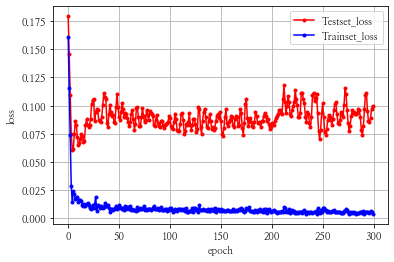

<class 'keras.layers.recurrent.SimpleRNN'>


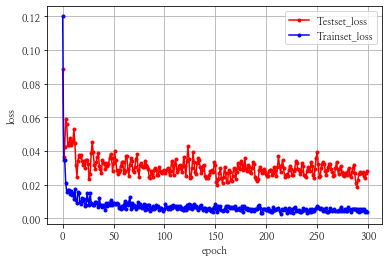

<class 'keras.layers.recurrent_v2.GRU'>


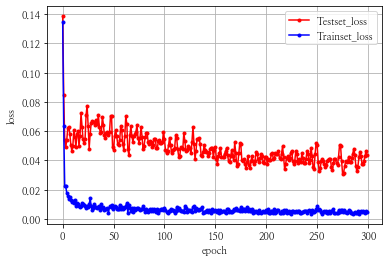

단독주택-경기[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[14:55:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


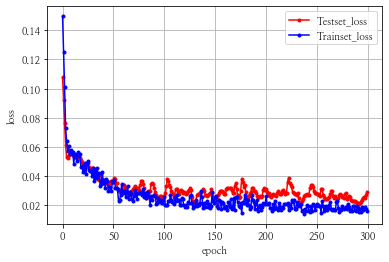

<class 'keras.layers.recurrent.SimpleRNN'>


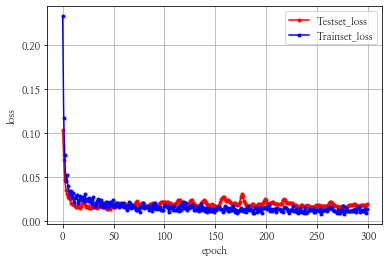

<class 'keras.layers.recurrent_v2.GRU'>


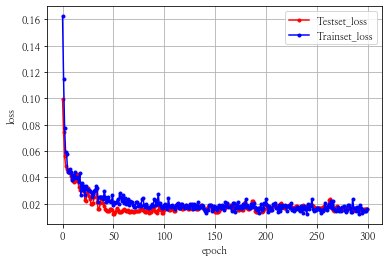

단독주택-인천[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[14:56:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


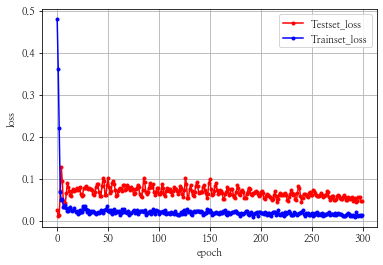

<class 'keras.layers.recurrent.SimpleRNN'>


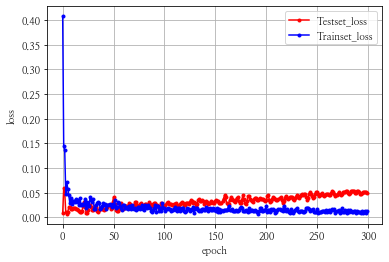

<class 'keras.layers.recurrent_v2.GRU'>


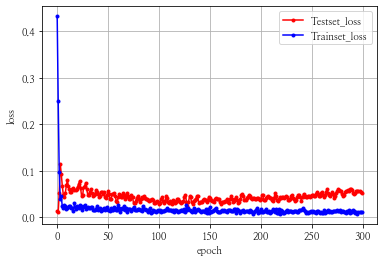

단독주택-부산[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[14:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


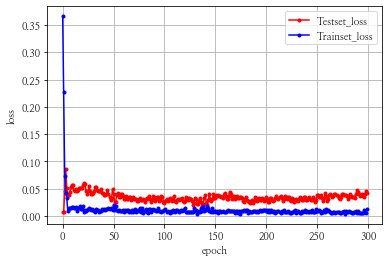

<class 'keras.layers.recurrent.SimpleRNN'>


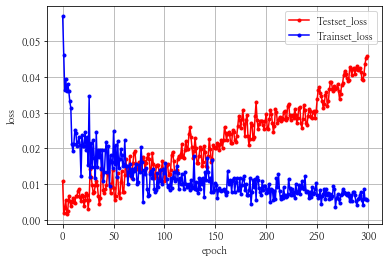

<class 'keras.layers.recurrent_v2.GRU'>


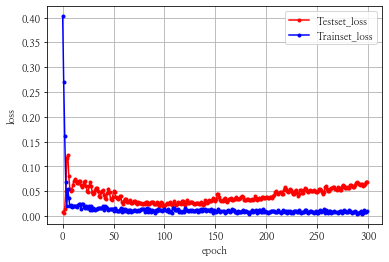

단독주택-대구[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[14:58:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:58:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


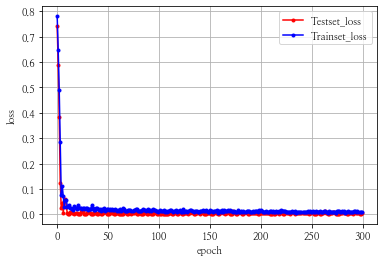

<class 'keras.layers.recurrent.SimpleRNN'>


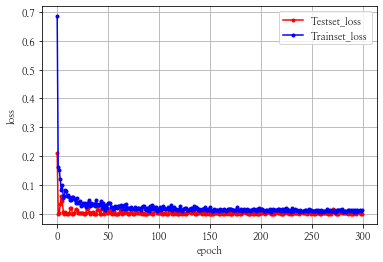

<class 'keras.layers.recurrent_v2.GRU'>


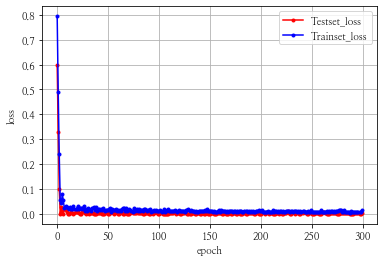

단독주택-광주[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[14:59:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


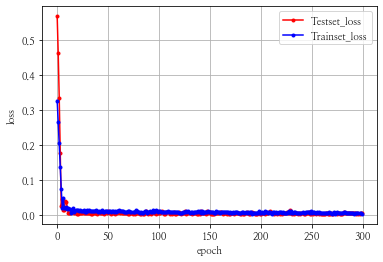

<class 'keras.layers.recurrent.SimpleRNN'>


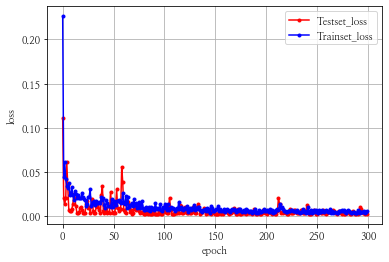

<class 'keras.layers.recurrent_v2.GRU'>


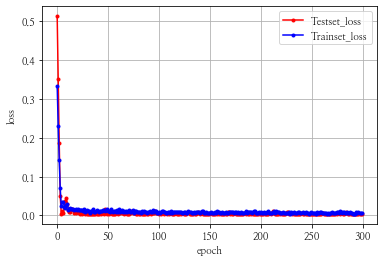

단독주택-대전[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:00:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


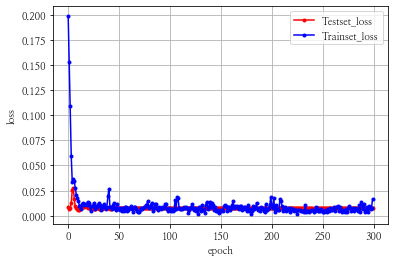

<class 'keras.layers.recurrent.SimpleRNN'>


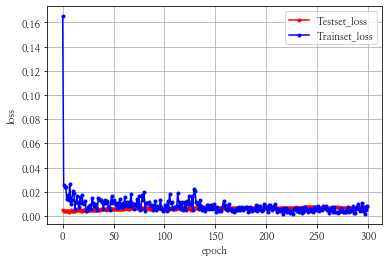

<class 'keras.layers.recurrent_v2.GRU'>


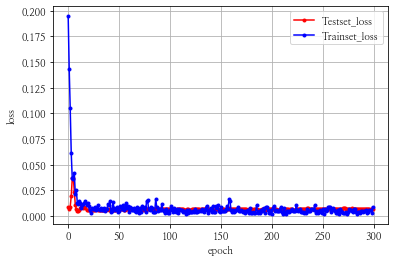

단독주택-울산[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:01:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:01:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


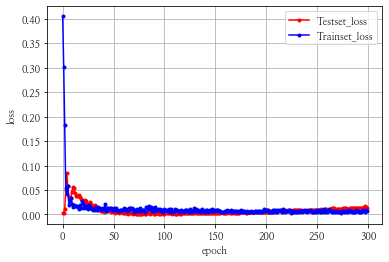

<class 'keras.layers.recurrent.SimpleRNN'>


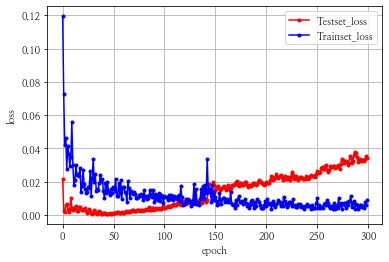

<class 'keras.layers.recurrent_v2.GRU'>


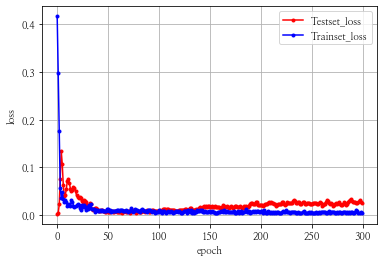

단독주택-세종[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


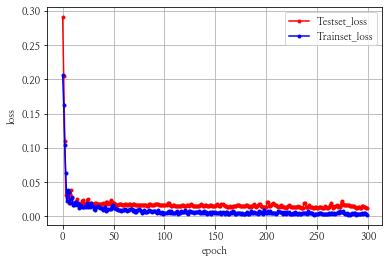

<class 'keras.layers.recurrent.SimpleRNN'>


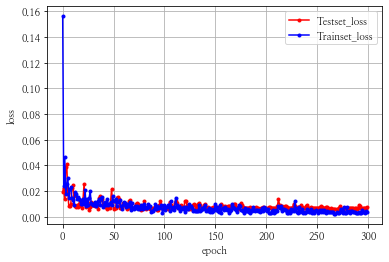

<class 'keras.layers.recurrent_v2.GRU'>


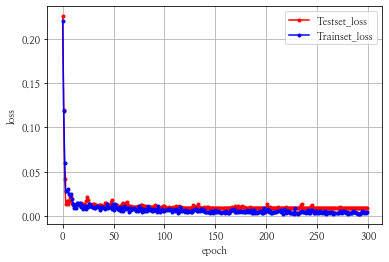

단독주택-강원[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:03:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


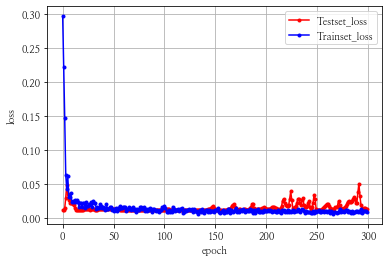

<class 'keras.layers.recurrent.SimpleRNN'>


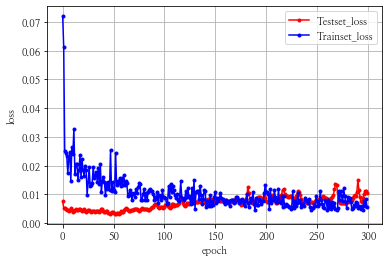

<class 'keras.layers.recurrent_v2.GRU'>


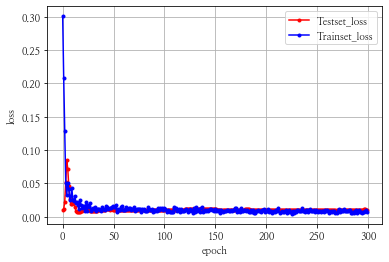

단독주택-충북[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


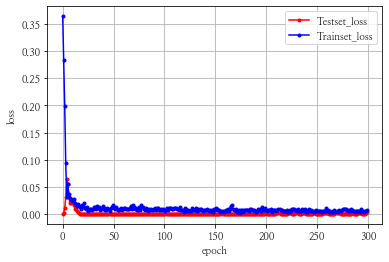

<class 'keras.layers.recurrent.SimpleRNN'>


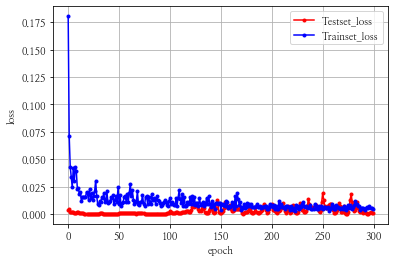

<class 'keras.layers.recurrent_v2.GRU'>


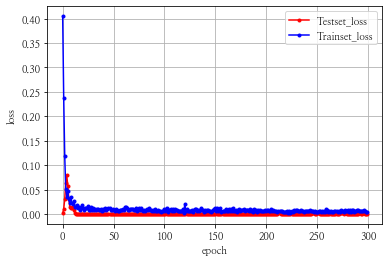

단독주택-충남[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:05:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


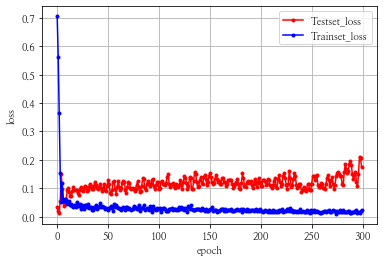

<class 'keras.layers.recurrent.SimpleRNN'>


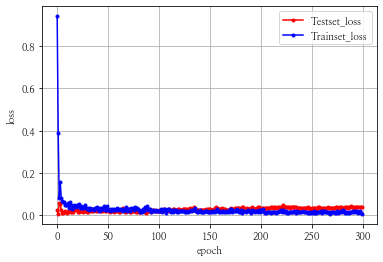

<class 'keras.layers.recurrent_v2.GRU'>


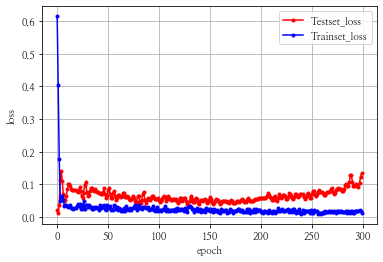

단독주택-전북[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:06:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


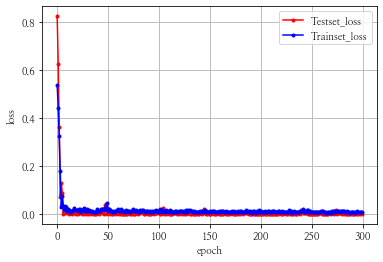

<class 'keras.layers.recurrent.SimpleRNN'>


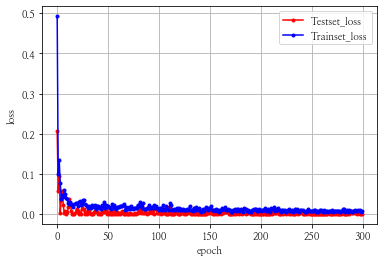

<class 'keras.layers.recurrent_v2.GRU'>


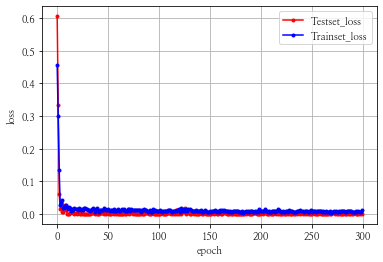

단독주택-전남[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:07:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


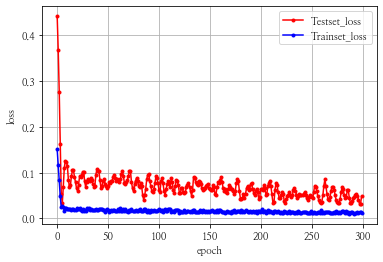

<class 'keras.layers.recurrent.SimpleRNN'>


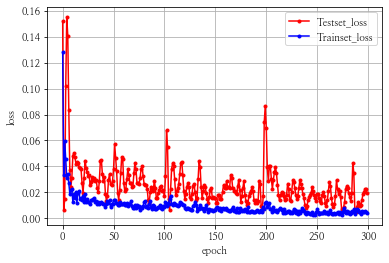

<class 'keras.layers.recurrent_v2.GRU'>


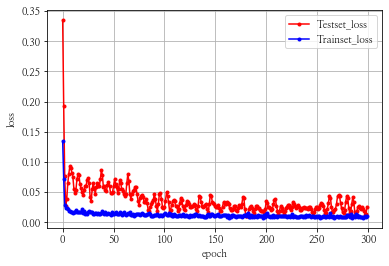

단독주택-경북[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:08:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


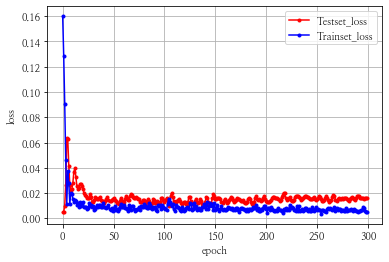

<class 'keras.layers.recurrent.SimpleRNN'>


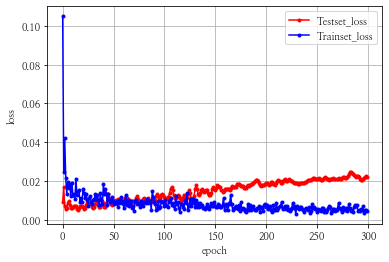

<class 'keras.layers.recurrent_v2.GRU'>


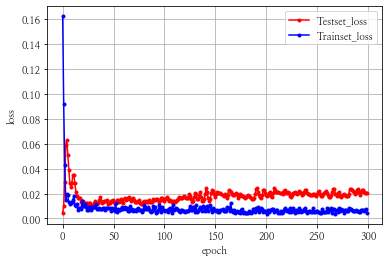

단독주택-경남[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:09:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


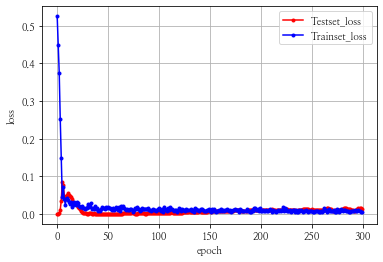

<class 'keras.layers.recurrent.SimpleRNN'>


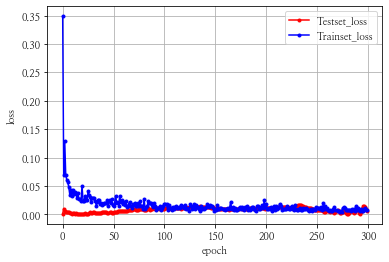

<class 'keras.layers.recurrent_v2.GRU'>


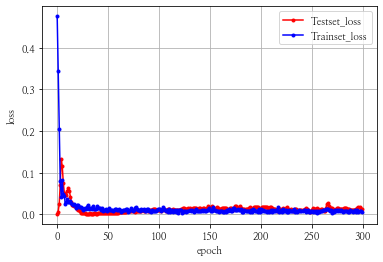

단독주택-제주[2017.11=100]
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'xgboost.sklearn.XGBRegressor'>
[15:10:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
<class 'keras.layers.recurrent_v2.LSTM'>


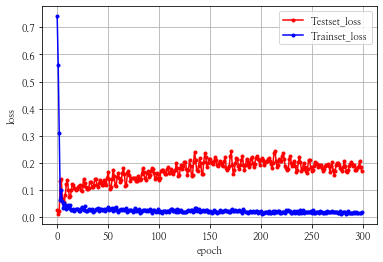

<class 'keras.layers.recurrent.SimpleRNN'>


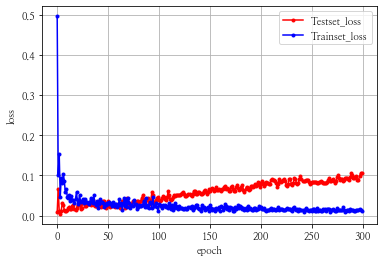

<class 'keras.layers.recurrent_v2.GRU'>


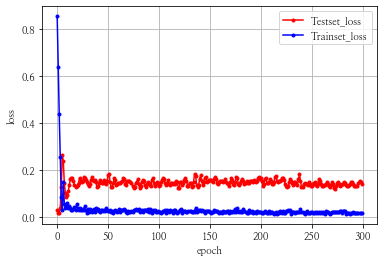

In [ ]:
predict_num = 12
cols = type_monthly.columns[78:95]

index = type_monthly.columns[0]
addDf = pd.DataFrame({index: ["2021-02-01", "2021-03-01", "2021-04-01", "2021-05-01",
                              "2021-06-01", "2021-07-01", "2021-08-01", "2021-09-01",
                              "2021-10-01", "2021-11-01", "2021-12-01", "2022-01-01"]})
type_df = pd.concat((type_monthly[[index]], addDf))
total_error = pd.DataFrame({"지역": [], "regression": [], "machine_learning": [], "deep_learning": []})

for col in cols:
  print(col)

  now_type = type_monthly[[col]]
  startNameIndex = col.index("-") + 1
  now_type.columns = [col[startNameIndex:startNameIndex + 2]]

  x_df, y_df = preprocess_to_df(now_type)
  x, y = preprocess_to_array(now_type)

  min_error = 100
  error = {"regression": [], "machine_learning": [], "deep_learning": []}
  for j, ensemble in enumerate([regression, machine_learning, deep_learning]):
    err, ensem = ensemble(x, y, predict_num)
    error[list(error.keys())[j]].append(err)

    if err < min_error: final_pred = ensem
  
  error["지역"] = [col[startNameIndex:startNameIndex + 2]]
  error = pd.DataFrame(error)
  total_error = pd.concat((total_error, error))

  addDf = pd.DataFrame({col[startNameIndex:startNameIndex + 2]:final_pred})
  now_type = pd.concat((now_type, addDf))

  type_df = pd.concat([type_df, now_type], axis=1)

if not os.path.exists("./test"):
  os.mkdir("./test")

type_df.set_index(index, inplace=True)
type_df.to_csv("./test/단독주택.csv")

total_error.set_index("지역", inplace=True)
total_error.to_csv("./test/단독주택_error.csv")

## 3. 예측 결과 시각화

#### 번외) 앞선 학습을 돌리기 싫다면 이렇게

In [ ]:
# system
import os
import warnings

# data
import numpy as np
import pandas as pd

# preprocessing 사실 이 키워드로 달면 안 되는데 굳이 더 세부적으로 세션 나누기 귀찮아.
import pickle

# visualize
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

In [ ]:
warnings.filterwarnings(action="ignore")

그림을 그리자.

In [ ]:
def df2LineGraph(df, title, y_t):
  size = len(df)
  cols = df.columns

  # visualize
  plt.rcParams["axes.unicode_minus"] = False
  plt.rcParams["axes.facecolor"] = "white"
  # rc("font", family="AppleGothic")
  plt.figure(figsize=(30, 10))

  for col in cols:
    plt.plot(df[col], label=col)

  plt.grid()
  plt.xticks([size - i for i in range(10, -1,- 1)], rotation=90)

  plt.legend(fontsize=10)
  plt.xlabel("날짜", fontsize=20)
  plt.ylabel(y_t, fontsize=20)
  plt.title(title, fontsize=35)
  plt.show()

In [ ]:
def to_bar_chart(x_tick, x_bar, t):
  minBar = min(x_bar); minIndex = x_bar.index(minBar)
  maxBar = max(x_bar); maxIndex = x_bar.index(maxBar)

  size = len(x_tick)
  x = np.arange(size)

  plt.figure(figsize=(15, 10))
  plt.bar(x_tick, x_bar)

  for i, val in enumerate(x_tick):
    if i == maxIndex: color = "red"
    elif i == minIndex: color = "brown"
    else: color = "black"
    plt.text(val, x_bar[i], round(x_bar[i], 3), fontsize=12, color=color,
             horizontalalignment="center", verticalalignment="bottom")
  
  plt.ylim([minBar - 0.3, maxBar + 0.3])
  plt.axhline(y=1, color="black", linewidth=1)

  plt.xlabel("지역", fontsize=13)
  plt.ylabel("2020년 5월 대비 ", fontsize=13)
  plt.title(t, fontsize=20)
  plt.show()

#### 데이터

In [ ]:
# apart = pd.read_csv("test/아파트.csv")
# alliance = pd.read_csv("test/연립다세대.csv")
home = pd.read_csv("test/단독주택.csv")

# L = [apart, alliance, home]
# titles = ["아파트", "연립다세대", "단독주택"]
L = [home]
titles = "단독주택"

# apart.set_index("Unnamed: 0", inplace=True)
# alliance.set_index("Unnamed: 0", inplace=True)
home.set_index("Unnamed: 0", inplace=True)

날짜 duplicate delete?

In [ ]:
types = []
for d in L:
  d = pd.concat((d[:-12], d[-10:]))
  types.append(d)

2020.05를 기준으로 regularization

In [ ]:
for d in types:
  cols = d.columns
  for col in cols:
    d[col] = d[col] / d.iloc[-9][col]

### 3.2 예측 모델 확인 및 예측값 시각화

모델별 loss와 선택된 모델로 예측한 지역별 가격 시각화

- 학습: 2015.06 ~ 2021.03
- 예측: 2021.04 ~ 2022.01
- 예측값은 2021.05를 기준으로 정규화 => 지금 가격 대비 미래의 가격

#### 3.2.3 단독주택

In [ ]:
house_error = pd.read_csv("test/단독주택_error.csv")
house_error

,지역,regression,machine_learning,deep_learning
0,서울,0.035144,0.060492,0.138474
1,경기,0.013673,0.031674,0.181579
2,인천,0.025338,0.167120,0.439732
3,부산,0.010793,0.123521,0.275196
4,대구,0.002999,0.004259,0.752902
5,광주,0.003286,0.008537,0.295531
6,대전,0.003373,0.007393,0.186031
7,울산,0.000805,0.064758,0.314065
8,세종,0.006708,0.014934,0.193988
9,강원,0.005485,0.038668,0.222913


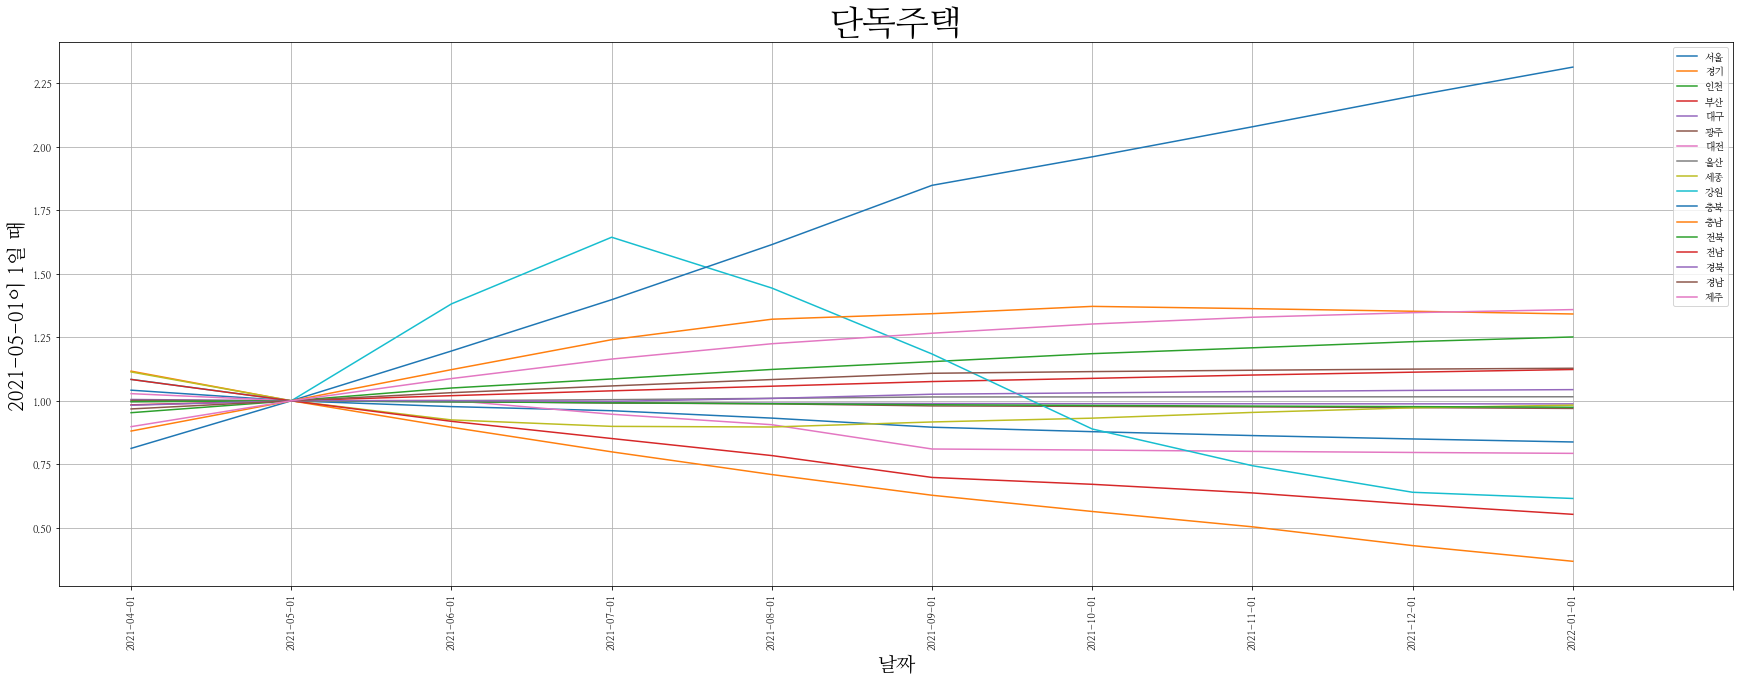

In [ ]:
df2LineGraph(types[0][-10:], titles, "2021-05-01이 1일 때")

### 3.3 최대상승 예상 지역 시각화

*작성자의 말을 빌리자면*

2022년 1월의 예측가격을 시각화합니다.<br />
y축은 2021년 5월의 가격을 1(가로선)이라고 할 때, 2022년 1월의 가격을 의미합니다.<br />
즉 현재 집을 샀을 때, 내년초에 집값이 어떻게 될지 지역별로 시각화 한 것입니다.

빨간색이 2021년 5월 대비 가장 상승할 것으로 예측되는 가격, 갈색이 2021년 5월 대비 가장 하락할 것으로 예측되는 가격입니다.

#### 3.2.3 단독주택

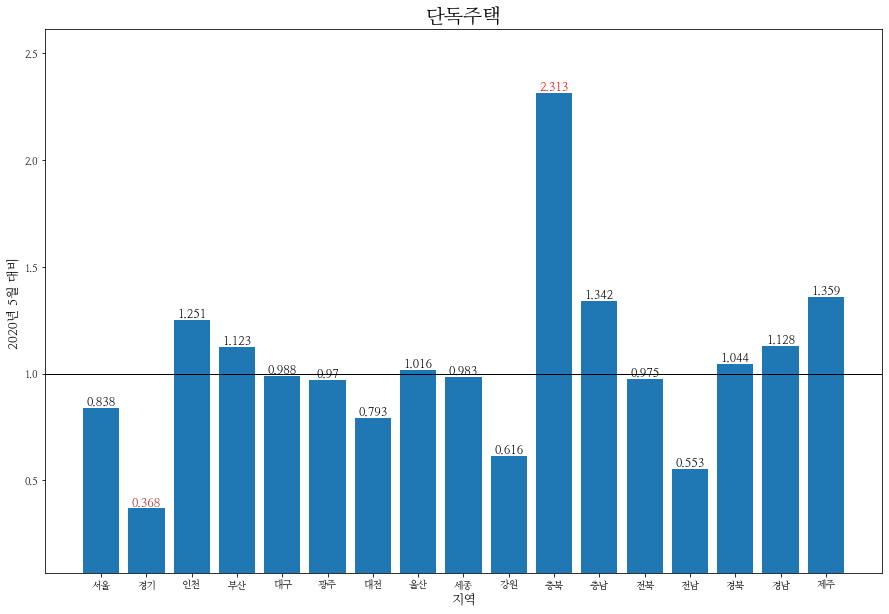

In [ ]:
to_bar_chart(list(types[0].columns), list(types[0].iloc[-1]), titles)